In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polyline
import uuid
from typing import Any
from nptyping import NDArray, Shape, Float
from collections import defaultdict
from sklearn.metrics import DistanceMetric

import sys
sys.path.insert(0, '../.')

from city_data import load_city_dataframe

In [2]:
df = pd.read_csv('../data/activities_small.csv') # read is small dataset

In [3]:
df.columns.tolist()

['id',
 'name',
 'distance',
 'moving_time',
 'elapsed_time',
 'total_elevation_gain',
 'type',
 'start_date',
 'start_date_local',
 'timezone',
 'achievement_count',
 'kudos_count',
 'comment_count',
 'athlete_count',
 'photo_count',
 'total_photo_count',
 'trainer',
 'commute',
 'manual',
 'private',
 'flagged',
 'average_speed',
 'max_speed',
 'average_watts',
 'max_watts',
 'weighted_average_watts',
 'kilojoules',
 'device_watts',
 'has_heartrate',
 'average_heartrate',
 'max_heartrate',
 'athlete_id',
 'map_id',
 'map_summary_polyline',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'state',
 'closest_city']

In [4]:
df = df[df['commute'] == 0] # drop all where commute = true
df = df[df['state'] == 'Colorado'] # drop all where state != Colorado
df.dropna(subset=['map_summary_polyline'], inplace=True) # drop all where map_summary_polyline is nan
df.reset_index(drop=True, inplace=True)
df.shape

(7164, 40)

In [5]:
df.head()

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,...,max_heartrate,athlete_id,map_id,map_summary_polyline,start_lat,start_lng,end_lat,end_lng,state,closest_city
0,467664896,Fat Bike in the snow at GM,12557.8,4111.0,4193.0,419.4,Ride,2016-01-10 19:13:47+00:00,2016-01-10 12:13:47,America/Denver,...,NaN,7360660,a467664896,w`gqFnpx`SDzEkDYw@wBApDdBjBGlD~@~@u@pCgJdD_AdM...,39.69,-105.15,39.69,-105.15,Colorado,Lakewood
1,308543489,"05/19/2015 Fruita, CO Horse Thief Bench",15941.8,3448.0,4356.0,322.0,Ride,2015-05-20 00:41:46+00:00,2015-05-19 18:41:46,America/Denver,...,148.0,113571,a308543489,scbnFjbgwSQjMzFhGnAzMJdEgBdBWtDpA`G|NnU`AxImAx...,39.17,-108.83,39.18,-108.83,Colorado,Fruita
2,432799746,Lunch Ride,77276.3,10158.0,15286.0,962.0,Ride,2015-11-14 19:21:32+00:00,2015-11-14 12:21:32,America/Denver,...,NaN,67365,a432799746,kf`sFhaiaS}KiBsAtFyI`ByeAjyBqBjNeJt@iC_EcGsAcn...,39.98,-105.24,39.98,-105.24,Colorado,Boulder
3,308543507,"05/20/2015 Fruita, CO Edge Loop",53577.9,14160.0,19563.0,1355.0,Ride,2015-05-20 15:55:46+00:00,2015-05-20 09:55:46,America/Denver,...,159.0,113571,a308543507,ez|nFrrnvSvRzu@aKhOsw@|FzDxFoKpZlMz_@qBpL}PrCk...,39.31,-108.71,39.31,-108.71,Colorado,Fruita
4,718012436,Lunch ride with Spencer,26395.2,4604.0,4971.0,391.7,Ride,2016-09-19 17:04:45+00:00,2016-09-19 11:04:45,America/Denver,...,NaN,153343,a718012436,sojsFd_naSs@r@|BsCMgBxMaAzByD~b@{@nAsCKaPhBy@v...,40.04,-105.26,40.04,-105.26,Colorado,Boulder


In [6]:
df.tail()

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,type,start_date,start_date_local,timezone,...,max_heartrate,athlete_id,map_id,map_summary_polyline,start_lat,start_lng,end_lat,end_lng,state,closest_city
7159,201196709,Flatirons CX,30092.3,6207.0,8995.0,248.4,Ride,2014-09-28 18:24:51+00:00,2014-09-28 12:24:51,America/Denver,...,164.0,58618,a201196709,ecwrFbnu`ScAaJNxIbDqCdGdGjMeAsR{AkAwQzEk@w@oF|...,39.94,-105.14,39.94,-105.13,Colorado,Superior
7160,540310403,Green is Green!,13258.3,5679.0,6034.0,391.0,Run,2016-04-09 14:58:44+00:00,2016-04-09 08:58:44,America/Denver,...,NaN,2036127,a540310403,yveqF`ky`SbJp@rBtOOhMaEmEaJfBGjDaEiBwDfDoA_ElA...,39.68,-105.16,39.68,-105.16,Colorado,Lakewood
7161,419462029,Fruita Fun,23956.0,6571.0,9191.0,498.9,Ride,2015-10-24 16:52:16+00:00,2015-10-24 10:52:16,America/Denver,...,NaN,6140375,a419462029,so_oF~rnvStLVGaIrb@pK|Ea@zX~HpBk@lEvG_@_PiDiGo...,39.32,-108.71,39.32,-108.71,Colorado,Fruita
7162,133462926,Niner GBS Lunch Ride,30653.5,6239.0,7384.0,685.3,Ride,2014-04-23 18:26:38+00:00,2014-04-23 12:26:38,America/Denver,...,185.0,727428,a133462926,smtqF|xfaSNgAaAF}L`LkFuKag@`e@ix@JqE}IaIjA?iBa...,39.76,-105.23,39.76,-105.23,Colorado,Golden
7163,637041556,Afternoon Ride,8550.8,2842.0,3058.0,18.6,Run,2016-07-08 23:35:06+00:00,2016-07-08 17:35:06,America/Denver,...,148.0,645904,a637041556,goxvFdsj`SLjRmBbFqGhF{CzQn@vOyCjEsCbAgAqC{@w[u...,40.60,-105.08,40.60,-105.08,Colorado,Fort Collins


In [7]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367000 * c
    return m

    

def haversine_sklearn(lon, lat):
    haversine = DistanceMetric.get_metric('haversine')
    latlon = np.hstack((lat[:, np.newaxis], lon[:, np.newaxis]))
    c = haversine.pairwise(latlon)
    m = 6367000 * c
    return m

In [8]:
# compute pairwise great circle distances for all start lat/longs 
dsts = haversine_sklearn(df.start_lng.values, df.start_lat.values)


In [9]:
il1 = np.tril_indices(dsts.shape[0])
dsts[il1] = -1

In [10]:
print("pairwise distances maximum:", dsts.max())

pairwise distances maximum: 19572217.70272183


In [11]:
# all pairs of indices with distances less than 100m apart
pairs = np.argwhere((dsts <= 100) & (dsts > -1))

In [12]:
def create_mapping(pairs: np.array) -> dict:
    """
    Map index keys to list of index values for all pairs of indexes
    """
    mapping = defaultdict(list)
    for pair in pairs:
        mapping[pair[0]].append(pair[1])

    return mapping

In [13]:
start_clusters = create_mapping(pairs)

In [62]:
def poly_decode_flatten(poly: str) -> NDArray[Shape["*"], Float]:
    return  np.array(polyline.decode(poly)).flatten()

In [63]:

poly1 = poly_decode_flatten(df.map_summary_polyline.iloc[0])

In [64]:
poly2 = poly_decode_flatten(df.map_summary_polyline.iloc[2574])

In [65]:
len(poly1)

170

In [66]:
len(poly2)

122

In [18]:
def polytrim(poly1: NDArray[Shape["*"], Float], poly2: NDArray[Shape["*"], Float]) -> NDArray[Shape["*"], Float]:
    """
    trim polyline 1 to be the same length as polyline 2
    """
    diff = len(poly1) - len(poly2)
    assert diff > 0
    rands = np.random.choice(np.arange(0, len(poly1)-2, 2), int(diff/2), replace=False)
    return np.delete(poly1, np.hstack((rands,rands+1)))

def euclid(poly1: NDArray[Shape["*"], Float], poly2: NDArray[Shape["*"], Float]) -> float:
    """
    compute euclidean distance between polylines
    """
    if len(poly1) > len(poly2):
        poly1 = polytrim(poly1, poly2)
    elif len(poly1) < len(poly2):
        poly2 = polytrim(poly2, poly1)
    return np.linalg.norm(np.subtract(poly1, poly2))

In [19]:
test = polytrim(poly1, poly2)
assert len(test) == len(poly2)

In [20]:
pair_dsts_lookup = defaultdict(list)
pair_dsts = [] # keep a list of values for global comparison
for ix1, ix_list in start_clusters.items():
    for ix2 in ix_list:
        p1 = np.array(polyline.decode(df.map_summary_polyline.iloc[ix1])).flatten()
        p2 = np.array(polyline.decode(df.map_summary_polyline.iloc[ix2])).flatten()
        dist = euclid(p1, p2)
        pair_dsts_lookup[ix1].append({'ix': ix2, 'dist': dist})
        pair_dsts.append(dist)

pair_dsts = np.array(pair_dsts)

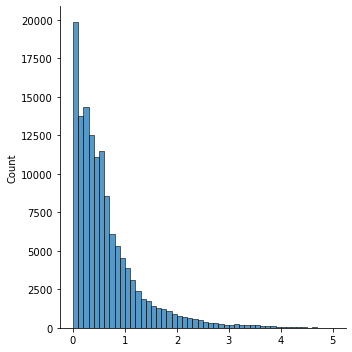

In [21]:
# the histogram of the data
sns.displot(pair_dsts[pair_dsts < 5.], bins=50)

In [22]:
bin_info = {1: '<.001', 2: '>=.001, <.002', 3: '>=.002, <.005', 4: '>=.005, <.01', 5: '>=.01'}
bins = defaultdict(list)
for ix1, dict_list in pair_dsts_lookup.items():
    for _dict in dict_list:
        if _dict['dist'] < .001:
            bins[1].append((ix1, _dict['ix']))
        elif (_dict['dist'] >= .001) and (_dict['dist'] < .002):
            bins[2].append((ix1, _dict['ix']))
        elif (_dict['dist'] >= .002) and (_dict['dist'] < .005):
            bins[3].append((ix1, _dict['ix']))
        elif (_dict['dist'] >= .005) and (_dict['dist'] < .01):
            bins[4].append((ix1, _dict['ix']))
        else:
            bins[5].append((ix1, _dict['ix']))

In [23]:
for bin_id, lim in bin_info.items():
    print("Bin limits: %s" % lim)
    print("Count pairs: %d" % len(bins[bin_id]))
    print()

Bin limits: <.001
Count pairs: 254

Bin limits: >=.001, <.002
Count pairs: 119

Bin limits: >=.002, <.005
Count pairs: 566

Bin limits: >=.005, <.01
Count pairs: 1845

Bin limits: >=.01
Count pairs: 130399



In [24]:
for _id in range(1, 6):
    for pair in random.sample(bins[_id], 10):
        ix1, ix2 = pair
        display(pd.concat([df.loc[ix1], df.loc[ix2]], axis=1).loc[['id', 'name', 'type', 'start_lat', 'start_lng', 'total_elevation_gain', 'distance'], :])

,2567,6026
id,328905207,321677178
name,"06/18/2015 Boulder, CO",Crack of Dawn Ride
type,Ride,Ride
start_lat,40.06,40.06
start_lng,-105.16,-105.16
total_elevation_gain,517.0,0.0
distance,55777.0,0.0


,6488,6491
id,629174130,629174142
name,Morning Run,Morning Run
type,Run,Run
start_lat,39.64,39.64
start_lng,-105.28,-105.28
total_elevation_gain,302.8,302.8
distance,9205.3,9205.3


,67,2379
id,689176854,486811820
name,Evening Ride,Evening Ride
type,Ride,Ride
start_lat,39.79,39.79
start_lng,-104.76,-104.76
total_elevation_gain,0.0,113.0
distance,37454.5,317.6


,1001,6932
id,253212155,262698939
name,"02/10/2015 Boulder, Colorado","02/26/2015 Boulder, Colorado"
type,Ride,Ride
start_lat,40.03,40.03
start_lng,-105.25,-105.25
total_elevation_gain,0.0,0.0
distance,0.0,7.3


,2379,6376
id,486811820,751070608
name,Evening Ride,Evening Ride
type,Ride,Ride
start_lat,39.79,39.79
start_lng,-104.76,-104.76
total_elevation_gain,113.0,0.0
distance,317.6,25659.1


,4640,4643
id,402673304,402673314
name,Lunch Run,Lunch Run
type,Run,Run
start_lat,39.68,39.68
start_lng,-104.95,-104.95
total_elevation_gain,35.3,35.3
distance,10265.3,10265.3


,2359,5458
id,425470000,298343802
name,Evening Activity,"05/04/2015 Colorado Springs, Colorado"
type,Workout,Ride
start_lat,39.0,39.0
start_lng,-104.79,-104.79
total_elevation_gain,0.0,10702.0
distance,19.3,74.5


,47,608
id,343933142,343935562
name,Evening Ride,Evening Ride
type,Ride,Ride
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,6418.8,6418.8


,1803,6943
id,116399751,262698976
name,still sick,"03/01/2015 Boulder, CO"
type,Ride,Ride
start_lat,39.98,39.98
start_lng,-105.24,-105.24
total_elevation_gain,0.0,16.0
distance,5.5,6.0


,3324,6507
id,278149300,433614802
name,"04/01/2015 Denver, CO",Spin with Andrew and Matt
type,Ride,Ride
start_lat,39.69,39.69
start_lng,-104.91,-104.91
total_elevation_gain,0.0,192.0
distance,6947.5,32542.0


,1211,1215
id,353899830,353899840
name,Aspen Xterra,"07/25/2015 Carbondale, Colorado"
type,Swim,Workout
start_lat,39.39,39.39
start_lng,-107.08,-107.08
total_elevation_gain,0.0,3.0
distance,1375.7,109.0


,453,3609
id,539232136,539245867
name,Morning Ride,Course Recon Buff RR
type,Ride,Ride
start_lat,40.18,40.18
start_lng,-105.18,-105.18
total_elevation_gain,152.3,137.4
distance,29291.7,29126.7


,257,4616
id,639632396,421883928
name,"Lots of ""Ready Gos"" at NP",NP Clovers 15+2
type,Run,Run
start_lat,39.74,39.74
start_lng,-104.99,-104.99
total_elevation_gain,0.0,0.0
distance,1184.4,5440.2


,3932,4950
id,189022961,153500896
name,"09/02/2014 Boulder, CO otb","06/14/2014 Boulder, CO"
type,Run,Run
start_lat,40.06,40.06
start_lng,-105.28,-105.28
total_elevation_gain,46.0,45.0
distance,5631.3,5507.9


,3296,3377
id,696268866,766619750
name,Still didn't get lapped by J-Pow.,Feedback cx warmup
type,Ride,Ride
start_lat,39.74,39.74
start_lng,-105.21,-105.21
total_elevation_gain,188.0,0.0
distance,17391.7,147.7


,1773,6672
id,593501706,145781424
name,Morning Ride,Run BolderBoulder w Maddy
type,Ride,Run
start_lat,40.02,40.02
start_lng,-105.25,-105.25
total_elevation_gain,122.0,60.9
distance,10276.3,10281.5


,430,3109
id,695555716,313799943
name,"If I just run a little bit more every month, e...","05/27/2015 Denver, Colorado"
type,Run,Run
start_lat,39.74,39.74
start_lng,-104.99,-104.99
total_elevation_gain,0.0,0.0
distance,6782.1,5766.9


,2563,4760
id,222047155,447500501
name,"11/18/2014 Boulder, CO","Wow, that was slow."
type,Ride,Run
start_lat,40.05,40.05
start_lng,-105.29,-105.29
total_elevation_gain,0.0,650.0
distance,0.0,8818.5


,1064,5429
id,259527290,206069019
name,"02/24/2015 Boulder, CO","10/08/2014 Boulder, CO"
type,Ride,Ride
start_lat,40.04,40.04
start_lng,-105.26,-105.26
total_elevation_gain,2.0,157.0
distance,8.8,16911.2


,1453,2296
id,368580834,211560202
name,"08/12/2015 Highlands Ranch, Colorado",Morning Ride
type,Run,Ride
start_lat,39.55,39.55
start_lng,-105.01,-105.01
total_elevation_gain,0.0,631.0
distance,1041.1,66616.1


,332,1351
id,372245863,372250406
name,Apple Meadows CX,Apple Meadows CX 1.0
type,Ride,Ride
start_lat,39.81,39.81
start_lng,-105.21,-105.21
total_elevation_gain,0.0,0.0
distance,1506.6,2158.2


,1752,6625
id,225189273,193229274
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,1335.6,1503.8


,3708,4101
id,639123114,639124964
name,Evening Run,BRC fun runnin
type,Run,Run
start_lat,39.72,39.72
start_lng,-104.96,-104.96
total_elevation_gain,27.1,26.7
distance,5466.8,5395.6


,1412,2573
id,446699572,572009447
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,2157.1,1405.0


,7043,7138
id,714635705,465074978
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,2044.8,1798.9


,4997,5519
id,187087065,280323356
name,Afternoon Constitutional,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,1065.1,972.4


,1215,1217
id,353899840,353899843
name,"07/25/2015 Carbondale, Colorado",Aspen Xterra
type,Workout,Run
start_lat,39.39,39.39
start_lng,-107.08,-107.08
total_elevation_gain,3.0,54.0
distance,109.0,4010.1


,2786,2804
id,813182844,603729849
name,Morning Run,NP - Civic Center Dice
type,Run,Run
start_lat,39.74,39.74
start_lng,-104.99,-104.99
total_elevation_gain,0.0,0.0
distance,3310.7,1738.2


,6045,6275
id,234645422,176712578
name,"11/15/2014 Boulder, Colorado","07/13/2014 Boulder, CO"
type,Ride,Workout
start_lat,40.07,40.07
start_lng,-105.23,-105.23
total_elevation_gain,127.0,0.0
distance,15660.6,119.1


,5620,6425
id,110387297,170946156
name,"01/31/2014 Boulder, CO","07/25/2014 Boulder, CO"
type,Ride,Ride
start_lat,39.98,39.98
start_lng,-105.24,-105.24
total_elevation_gain,0.0,271.0
distance,14.8,26318.8


,5063,6814
id,398480973,576484766
name,Run to/from NP yoga (thanks Alex!),Night Ride
type,Run,Ride
start_lat,39.73,39.73
start_lng,-104.96,-104.96
total_elevation_gain,25.3,0.0
distance,5301.5,0.1


,1968,4099
id,357048731,575948256
name,"07/27/2015 Boulder, Colorado",Morning Ride
type,Ride,Ride
start_lat,40.0,40.0
start_lng,-105.17,-105.17
total_elevation_gain,135.0,4.0
distance,28958.9,150.2


,1116,4896
id,404755290,557339444
name,School,School
type,Ride,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,3647.0,1991.1


,6348,6837
id,499674361,523269650
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,1863.5,2651.2


,4974,5182
id,105665682,374364301
name,"01/09/2014 Brighton, CO",Afternoon Ride
type,Ride,Ride
start_lat,39.98,39.98
start_lng,-104.82,-104.82
total_elevation_gain,94.0,116.6
distance,32249.8,32454.0


,2910,6932
id,275526101,262698939
name,"03/25/2015 Boulder, CO","02/26/2015 Boulder, Colorado"
type,Ride,Ride
start_lat,40.03,40.03
start_lng,-105.25,-105.25
total_elevation_gain,8.0,0.0
distance,1289.4,7.3


,1740,7080
id,735321444,535591503
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,2064.7,1888.0


,2886,6644
id,407122282,406876719
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,2030.3,1813.1


,4420,6943
id,318857694,262698976
name,"01/31/2015 Boulder, CO","03/01/2015 Boulder, CO"
type,Ride,Ride
start_lat,39.98,39.98
start_lng,-105.24,-105.24
total_elevation_gain,0.0,16.0
distance,0.1,6.0


,3533,5410
id,866139081,216316449
name,School,School
type,Walk,Walk
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,0.0
distance,1967.8,1464.1


,41,2059
id,694681788,295445276
name,Lunch Ride,I guess running is pretty cool too...
type,Ride,Run
start_lat,40.02,40.02
start_lng,-105.23,-105.23
total_elevation_gain,110.9,25.0
distance,17529.9,5004.8


,3044,5062
id,142881775,478959170
name,Hardware Store And Beeeer Run with My Son,Fool's Errand #2
type,Ride,Ride
start_lat,39.76,39.76
start_lng,-105.04,-105.04
total_elevation_gain,14.1,25.3
distance,7981.0,2606.6


,314,1894
id,871105833,204910594
name,Worlds Ride & Extra,"10/08/2014 Littleton, CO"
type,Ride,Ride
start_lat,39.62,39.62
start_lng,-105.14,-105.14
total_elevation_gain,1591.0,591.0
distance,118506.0,31644.8


,821,4377
id,596381194,405555794
name,Playground again,DIA Circumnavigation
type,Walk,Ride
start_lat,39.76,39.76
start_lng,-104.88,-104.88
total_elevation_gain,0.0,341.1
distance,1021.0,89184.2


,514,3236
id,226494622,251239716
name,Lunch Ride,Ute Valley Lunch
type,Ride,Ride
start_lat,38.9,38.9
start_lng,-104.85,-104.85
total_elevation_gain,261.7,479.0
distance,13193.6,18306.8


,1874,7140
id,289152948,596732382
name,"04/14/2015 Golden, CO",Nice a steady pace.
type,Ride,Ride
start_lat,39.81,39.81
start_lng,-105.2,-105.2
total_elevation_gain,1095.0,965.0
distance,72693.0,45055.0


,4313,5808
id,246171963,216556447
name,Windy day in the mountains,Sunshine
type,Ride,Ride
start_lat,40.02,40.02
start_lng,-105.23,-105.23
total_elevation_gain,718.5,495.0
distance,46347.9,27452.3


,1972,6114
id,723263918,464546021
name,Morning Ride,Weld Dirt Loop
type,Ride,Ride
start_lat,40.04,40.04
start_lng,-105.08,-105.08
total_elevation_gain,245.0,317.0
distance,36939.2,44484.9


,1385,3390
id,293296456,756038064
name,ButterGold,Afternoon Ride
type,Ride,Ride
start_lat,40.03,40.03
start_lng,-105.29,-105.29
total_elevation_gain,413.0,142.0
distance,136693.0,14703.5


,3684,3750
id,735854158,322977652
name,Panache CX Clinic,"06/10/2015 Boulder, Colorado"
type,Ride,Ride
start_lat,40.03,40.03
start_lng,-105.25,-105.25
total_elevation_gain,61.0,603.0
distance,7847.1,42195.2


In [26]:
cities_df = load_city_dataframe()

In [40]:
cities_df.columns

Index(['city', 'city_ascii', 'state_id', 'state_name', 'county_fips',
       'county_name', 'lat', 'lng', 'population', 'density', 'source',
       'military', 'incorporated', 'timezone', 'ranking', 'zips', 'id'],
      dtype='object')

In [88]:
def find_closest_city(row):
    poly = poly_decode_flatten(row.map_summary_polyline)

    lat_s, lon_s = poly[:2]
    lat_e, lon_e = poly[-2:]

    cities_df_subset = cities_df[cities_df.state_name == 'Colorado']
    lon_vals = cities_df_subset['lng'].values
    lat_vals = cities_df_subset['lat'].values
    a = haversine_np(lon_vals, lat_vals, lon_s, lat_s)
    b = haversine_np(lon_vals, lat_vals, lon_e, lat_e)
    c = haversine_np(lon_s, lat_s, lon_e, lat_e)

    p = (a+b+c)/2
    m2 = (p*(p-a)*(p-b)*(p-c))**.5
    return cities_df_subset.iloc[m2.argmin()]

def get_poly_normalized_to_closest_city(row):
    find_closest_city(row)
    

Signature: polyline.encode(coordinates, precision=5, geojson=False)
Docstring:
Encode a set of coordinates in a polyline string.

:param coordinates: List of coordinate tuples, e.g. [(0, 0), (1, 0)]. Unless geojson is set to True, the order
    is expected to be (lat, lon).
:param precision: Precision of the coordinates to encode. Google Maps uses 5, OpenStreetMap uses 6.
    The default value is 5.
:param geojson: Set to True in order to encode (lon, lat) tuples.
:return: The encoded polyline string.
File:      ~/mambaforge/envs/findingepics/lib/python3.10/site-packages/polyline/__init__.py
Type:      function


In [89]:
find_closest_city(df.iloc[0])

city            St. Ann Highlands
city_ascii      St. Ann Highlands
state_id                       CO
state_name               Colorado
county_fips                  8013
county_name               Boulder
lat                       39.9873
lng                     -105.4559
population                    486
density                     134.0
source                      shape
military                    False
incorporated                False
timezone           America/Denver
ranking                         3
zips                        80466
id                     1840028527
Name: 20006, dtype: object

In [29]:
def 

def get_closest_city(row):
    cities_df_subset = cities_df[cities_df.state_name == row["state"]]
    row["start_lat"], row["start_lng"]


0

In [ ]:
df.apply(get_closest_city)

In [27]:
copy_final_clusters = final_clusters.copy()
for idx1, other_idxs in copy_final_clusters.iteritems():
    for idx2 in other_idxs:
        final_clusters.pop(idx2, None)

NameError: name 'final_clusters' is not defined

In [ ]:
for idx1, other_idxs in final_clusters.iteritems():
    activity_id = uuid.uuid4().hex[:8] # 8 char activity key
    mask_arr = np.array([idx1] + other_idxs)
    df.loc[mask_arr, ['activity_id']] = activity_id

In [ ]:
final_clusters

In [ ]:
# set all remaining activities without a cluster assignment to a new a activity key
mask1 = df['activity_id'] == 0
cluster_center_idxs = np.concatenate((np.argwhere(df['activity_id'] == 0).ravel(), np.array(final_clusters.keys())))
df.loc[mask1, ['activity_id']] = df.loc[mask1, ['activity_id']].apply(lambda x: uuid.uuid4().hex[:8], 1)
cols = ['map_summary_polyline', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'activity_id']
df.loc[cluster_center_idxs, cols]

In [191]:
df.groupby(['activity_id']).count()['id'].order(ascending=False)

/Users/gmacmillan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: order is deprecated, use sort_values(...)
  if __name__ == '__main__':


activity_id
dd089616    231
93f1bb8f    129
9f67dc6a     82
cb07d7be     78
40a18b46     65
86e64eab     64
7b88ab3f     62
c8e8ba8d     57
cbaef092     55
da5714b7     54
c7e7d05e     51
3b1b13c5     48
250e5250     47
35bb644f     47
b2a97a5e     43
d669b03a     43
12e99e62     43
595348f9     37
c20abdd9     37
e54cbe0c     36
b45134e5     35
4b6fd133     34
8ea4e3f6     34
51daf7f2     34
9468eefa     31
46f82e94     30
88b8b029     30
b1070338     29
f56315e9     29
f8a9dee4     28
           ... 
a017f1ce      1
9b9d076d      1
9d792a31      1
9bceb274      1
9c1e0415      1
9c58a15c      1
9c5c8e5a      1
9c60ff10      1
9c7ecfe9      1
9c8fde1d      1
9c922ee6      1
9c96c7f0      1
9ca01fb9      1
9cbe4007      1
9d5608f4      1
9db6a96c      1
9fd55658      1
9dce9973      1
9dea4849      1
9e0ae457      1
9e469a6f      1
9e48fd32      1
9e5c9423      1
9ec9a1e1      1
9eccbb6b      1
9efdc6c1      1
9f511590      1
9f74ce96      1
9fc6aea4      1
00141355      1
Name: id, dt

In [193]:
final_clusters[0]

[466, 1818, 1873, 2731, 2790, 3904, 7025]

In [26]:
poly1

array([  39.97796, -105.14489,   39.97784, -105.14671,   39.98195,
       -105.14689,   39.98356, -105.14893,   39.98494, -105.14739,
         39.98715, -105.14857,   39.98999, -105.14437,   39.99064,
       -105.14441,   39.99033, -105.14521,   39.99137, -105.14805,
         39.99305, -105.14783,   39.99506, -105.14489,   39.99703,
       -105.14499,   39.99758, -105.14632,   39.99521, -105.14664,
         39.99512, -105.14962,   39.99385, -105.15121,   39.99377,
       -105.15303,   39.99293, -105.15296,   39.99107, -105.14988,
         39.98987, -105.15236,   39.98985, -105.15628,   39.9818 ,
       -105.15621,   39.98108, -105.16047,   39.98232, -105.16152,
         39.98218, -105.16373,   39.98069, -105.16529,   39.97853,
       -105.16542,   39.97799, -105.16655,   39.97815, -105.17082,
         39.97659, -105.17252,   39.97563, -105.17515,   39.97224,
       -105.17514,   39.972  , -105.18241,   39.96806, -105.18253,
         39.96796, -105.18423,   39.96563, -105.18443,   39.96